In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import matplotlib
import cm_xml_to_matplotlib as make_cmap

import celeri

plt.rcParams["text.usetex"] = False


In [3]:
# Constants and parameters
N_GRID_X = 500
N_GRID_Y = 500
MAKE_EIGENVECTOR_EXAMPLE_PLOT = False
N_CONTOUR_LEVELS = 10

KM2_TO_M2 = 1e6 # kilometers squared to meters squared
DYNECM_TO_NM = 1e-7 # dynes centimeters to Newton meters
SHEAR_MODULUS = 3e10 # Shear modulus (Pa)

cmap = make_cmap.make_cmap("w_ymiddle1.xml")

In [4]:
def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = matplotlib.path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


def rbf_interpolate(fill_value):
    # Observation coordinates and data
    x_vec = np.linspace(231, 239, N_GRID_X)
    y_vec = np.linspace(38, 52, N_GRID_Y)
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    y_mat = y_mat
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value

    # Package for RBFInterpolator
    xgrid = np.stack((x_mat, y_mat))
    xflat = xgrid.reshape(2, -1).T
    xobs = np.vstack((centroids_lon, centroids_lat)).T
    yobs = centroids_val
    yflat = scipy.interpolate.RBFInterpolator(
        xobs, yobs, kernel="cubic", smoothing=0.01, epsilon=1.5
    )(xflat)
    ygrid = yflat.reshape(N_GRID_X, N_GRID_Y)
    return xgrid, ygrid


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


def plot_slip_distributions(
    slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    interpolate_and_plot(slip_distribution_input[0::2])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    interpolate_and_plot(slip_distribution_estimated[0::2])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    interpolate_and_plot(slip_distribution_input[1::2])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    interpolate_and_plot(slip_distribution_estimated[1::2])

    plt.suptitle(suptitle_string)
    plt.show()


def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def get_synthetic_accumulated_slip(mesh, sources):
    slip_distribution = np.zeros(2 * mesh.n_tde)
    strike_slip_distribution = np.zeros(mesh.n_tde)
    dip_slip_distribution = np.zeros(mesh.n_tde)

    for i in range(sources.lon.size):
        source_to_mesh_centroid_lon = mesh.centroids[:, 0] - sources.lon[i]
        source_to_mesh_centroid_lat = mesh.centroids[:, 1] - sources.lat[i]

        source_to_mesh_centroid_distance = np.sqrt(
            source_to_mesh_centroid_lon**2.0 + source_to_mesh_centroid_lat**2.0
        )

        # Guassian slip pattern
        if sources.slip_type[i] == "strike_slip":
            strike_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )
        elif sources.slip_type[i] == "dip_slip":
            dip_slip_distribution += sources.magnitude[i] * np.exp(
                -((source_to_mesh_centroid_distance / 1.0) ** 2.0)
            )

    slip_distribution[0::2] = strike_slip_distribution  # Strike slip only
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    return slip_distribution


def plot_meshes(meshes, fill_value, ax, cmap_string):
    x_coords = meshes[0].meshio_object.points[:, 0]
    y_coords = meshes[0].meshio_object.points[:, 1]
    vertex_array = np.asarray(meshes[0].verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor="k",
        cmap=cmap_string,
        linewidth=0.1,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    return pc


def moment_magnitude_to_area_allen_and_hayes(moment_magnitude):
    """Calculate emperically estimated slip areas using
    relationships from:

    Allen and Hayes (2017), Alternative Rupture-Scaling
    Relationships for Subduction Interface and Other Offshore
    Environments, Bulletin of the Seismological Society of America,
    Vol. 107, No. 3, pp. 1240–1253, June 2017, doi: 10.1785/0120160255

    All values taken from their table 2

    Note: $S_2$ in the paper's notation is what we use for rupture_area

    Args:
        moment_magnitude: Array of moment magnitudes

    Returns:
        area: rupture area in meters squared
    """
    hinge_moment_magnitude = 8.63
    if moment_magnitude <= hinge_moment_magnitude:
        a = -5.62
        b = 1.22
    elif moment_magnitude > hinge_moment_magnitude:
        a = 2.23
        b = 0.31
    area = KM2_TO_M2 * 10 ** (a + b * moment_magnitude)
    return area


def get_gutenberg_richter_magnitudes(n_earthquakes, b_value, minimum_magnitude):
    rng = np.random.RandomState()
    magnitudes = minimum_magnitude + rng.exponential(
        1.0 / (-b_value / np.log10(np.e)), n_earthquakes
    )
    return magnitudes


def normalized_sigmoid(a, b, x):
    """
    Returns array of a horizontal mirrored normalized sigmoid function
    output between 0 and 1
    Function parameters a = center; b = width
    https://stackoverflow.com/questions/3985619/how-to-calculate-a-logistic-sigmoid-function-in-python
    """
    s = 1 / (1 + np.exp(b * (x - a)))
    return 1 * (s - np.min(s)) / (np.max(s) - np.min(s))  # normalize function to 0-1


# Visualize eigenvectors
def interpolate_and_plot(fill_value):
    # Interpolate values onto a regular grid for plotting
    # If the fill value has very little variation so it can be contoured
    if fill_value.ptp() < 1e-4:
        fill_value = 1e-4 * np.ones_like(fill_value)

    xgrid, ygrid = rbf_interpolate(fill_value)
    xflat = xgrid.reshape(2, -1).T
    inpolygon_vals = inpolygon(
        xflat[:, 0], xflat[:, 1], meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(inpolygon_vals, (N_GRID_X, N_GRID_Y))
    ygrid[~inpolygon_vals] = np.nan

    # Plot
    levels = np.linspace(-1.0, 1.0, N_CONTOUR_LEVELS)
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", message="No contour levels were found within the data range."
        )
        plt.contourf(*xgrid, ygrid, cmap=cmap, levels=levels, extend="both")
        plt.contour(
            *xgrid,
            ygrid,
            colors="k",
            linestyles="solid",
            linewidths=0.25,
            levels=levels,
        )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xticks([])
    plt.yticks([])

def get_hypocenter_triangle_to_all_triangles_distances(meshes, event):
    # Find distance between current index mesh triangle all others
    x_centroid = (
        meshes[0].x_centroid[event.hypocenter_triangle_index] - meshes[0].x_centroid
    )
    y_centroid = (
        meshes[0].y_centroid[event.hypocenter_triangle_index] - meshes[0].y_centroid
    )
    z_centroid = (
        meshes[0].z_centroid[event.hypocenter_triangle_index] - meshes[0].z_centroid
    )

    all_triangle_cartesian_centroid_coordinates = np.vstack(
        (x_centroid, y_centroid, z_centroid)
    ).T

    hypocenter_triangle_cartesian_centroid_coordinates = np.array(
        [
            x_centroid[event.hypocenter_triangle_index],
            y_centroid[event.hypocenter_triangle_index],
            z_centroid[event.hypocenter_triangle_index],
        ]
    ).T

    hypocenter_triangle_to_all_triangles_distances = scipy.spatial.distance.cdist(
        hypocenter_triangle_cartesian_centroid_coordinates,
        all_triangle_cartesian_centroid_coordinates,
        "euclidean",
    )

    hypocenter_triangle_to_all_triangles_distances = np.squeeze(
        hypocenter_triangle_to_all_triangles_distances
    )

    return hypocenter_triangle_to_all_triangles_distances


def event_generate_slip(event, eigenvalues, eigenvectors):
    event.slip = np.zeros(event.triangle_index.size)
    weights = np.random.randn(eigenvalues.size)
    for k in range(1, weights.size):
        event.slip += weights[k] * np.sqrt(eigenvalues[k]) * eigenvectors[:, k]
    event.slip = np.exp(event.slip)

    # Apply taper to slip.  This is ad hoc and may need revision
    distances = event.hypocenter_triangle_to_all_triangles_distances[event.triangle_index]
    taper_transition = 1.5 * np.mean(distances)
    taper_width = 10 / taper_transition # m

    slip_taper = normalized_sigmoid(taper_transition, taper_width, distances)
    event.slip = event.slip * slip_taper

    # After taper is applied rescale slip magnitudes to get the correct moment
    event.pre_scaled_moment = SHEAR_MODULUS * np.sum(
        event.slip * meshes[0].areas[event.triangle_index]
    )
    event.slip_scaling_factor = event.moment / event.pre_scaled_moment
    event.slip = event.slip * event.slip_scaling_factor
   
    event.slip_all_elements = np.zeros(meshes[0].n_tde)
    event.slip_all_elements[event.triangle_index] = event.slip

    return event

In [5]:
def create_event(meshes, probability):
    # Dictionary for storing `event` information for a single earthquake
    event = addict.Dict()

    # Select random event magnitude from GR distribution
    n_earthquakes = 1
    b_value = -1.0
    minimum_magnitude = 7.5
    event.moment_magnitude = get_gutenberg_richter_magnitudes(
        n_earthquakes, b_value, minimum_magnitude
    )

    event.moment_magnitude = np.array([9.0])
    # event.moment_magnitude = 8.5
    event.moment = 10 ** (1.5 * (event.moment_magnitude + 10.7) - 7.0)
    event.target_area = moment_magnitude_to_area_allen_and_hayes(event.moment_magnitude)
    event.total_mesh_area = np.sum(meshes[0].areas)

    # Select random triangle, should be based on coupling or slip deficit rate/history
    triangle_probabilities = probability
    event.hypocenter_triangle_index = np.random.choice(
        meshes[0].n_tde, 1, p=triangle_probabilities
    )

    # Calculate distance from hypocenter triangle toto all other triangles
    event.hypocenter_triangle_to_all_triangles_distances = (
        get_hypocenter_triangle_to_all_triangles_distances(meshes, event)
    )

    # Find the triangles close to the hypocenter that accumulate enough area to be a
    # part of the event rupture
    sorted_distance_index = np.argsort(
        event.hypocenter_triangle_to_all_triangles_distances
    )
    cumulative_area = np.cumsum(meshes[0].areas[sorted_distance_index])
    event.triangle_index = sorted_distance_index[
        np.where(cumulative_area < event.target_area)[0]
    ]
    event.actual_area = np.sum(meshes[0].areas[event.triangle_index])
    event.mean_slip = event.moment / (SHEAR_MODULUS * event.actual_area)

    # Calculate eigenvalues and eigenvectors for the current event area
    # Were not storing these in event because that would start to consume a
    # lot of RAM as we build histories of multiple events
    event.n_eigenvalues = event.triangle_index.size
    eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
        event.n_eigenvalues,
        (meshes[0].x_centroid[event.hypocenter_triangle_index] - meshes[0].x_centroid)[
            event.triangle_index
        ],
        (meshes[0].y_centroid[event.hypocenter_triangle_index] - meshes[0].y_centroid)[
            event.triangle_index
        ],
        (meshes[0].z_centroid[event.hypocenter_triangle_index] - meshes[0].z_centroid)[
            event.triangle_index
        ],
    )

    # Generate random slip distribution for current rupture patch
    event = event_generate_slip(event, eigenvalues, eigenvectors)
    return event


def get_probability(slip_deficit, t):
    # Map slip defict to earthquake probability
    probability = 1 - normalized_sigmoid(1e-5, 1e-1, slip_deficit)
    probability = probability - np.min(probability)
    probability = probability / np.max(probability)
    probability = probability / np.sum(probability)
    return probability


In [6]:
# COMMAND_FILE_NAME = "../data/command/western_north_america_command_dense.json"
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"

command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)


2022-09-09 22:04:01.963 | INFO     | celeri.celeri:get_logger:122 - Read: ../data/command/western_north_america_command.json
2022-09-09 22:04:01.964 | INFO     | celeri.celeri:get_logger:123 - RUN_NAME: 2022-09-09-22-04-01
2022-09-09 22:04:01.964 | INFO     | celeri.celeri:get_logger:124 - Write log file: ../runs/2022-09-09-22-04-01/2022-09-09-22-04-01.log
2022-09-09 22:04:01.964 | INFO     | celeri.celeri:read_data:129 - Reading data files
2022-09-09 22:04:01.969 | SUCCESS  | celeri.celeri:read_data:133 - Read: ../data/segment/western_north_america_segment.csv
2022-09-09 22:04:01.971 | SUCCESS  | celeri.celeri:read_data:138 - Read: ../data/block/western_north_america_block.csv
2022-09-09 22:04:01.971 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/mesh/western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2022-09-09 22:04:01.997 | SUCCESS  | celeri.celeri:read_data:265 - Read: ../data/mesh/cascadia.msh
2022-09-09 22:04:02.000 | SUCCESS  | celeri.celeri:read_data:301 - Read: ../data/station/western_north_america_station.csv
2022-09-09 22:04:02.001 | INFO     | celeri.celeri:read_data:316 - No mogi_file_name
2022-09-09 22:04:02.002 | INFO     | celeri.celeri:read_data:338 - No sar_file_name


# Outline
1. Calculate kinematically informed random epicenter
   - Pick a mesh element (`np.random.choice`) with probability:
     $$P(c(t)) = \frac{1}{1+e^{-c(t)}} + \mathrm{history}$$
     where $c(t)$ is the coupling rate at time ($t$).  This is an instantaneous formulation.  We could also do this with a more history dependent formulation.  This could include dropping probabilities after an event ruptures a triangular element much like a "state" effect.  This could sort of halo certain regions
2. Calculate random magnitude 
   - Could be Gutenberg Richter or drawn from a history dependent Omori style aftershock frequency law
   - Gutenberg Richter formulation:
3. Calculate approximate rupture area, $a$ 
   - Empirical scaling law (Allen and Hayes, Wells and Coppersmith)
4. Find subset of $n$ triangles with areas that sum to $a+$  some factor
$$a^{+}< \alpha_t \sum_k a_k$$
5. Calculate eigenfunctions for these triangles
6. Generate random Gaussian slip pattern
	- Should I taper towards edges?
7. Rescale random Gaussian slip pattern to get the magnitude correct

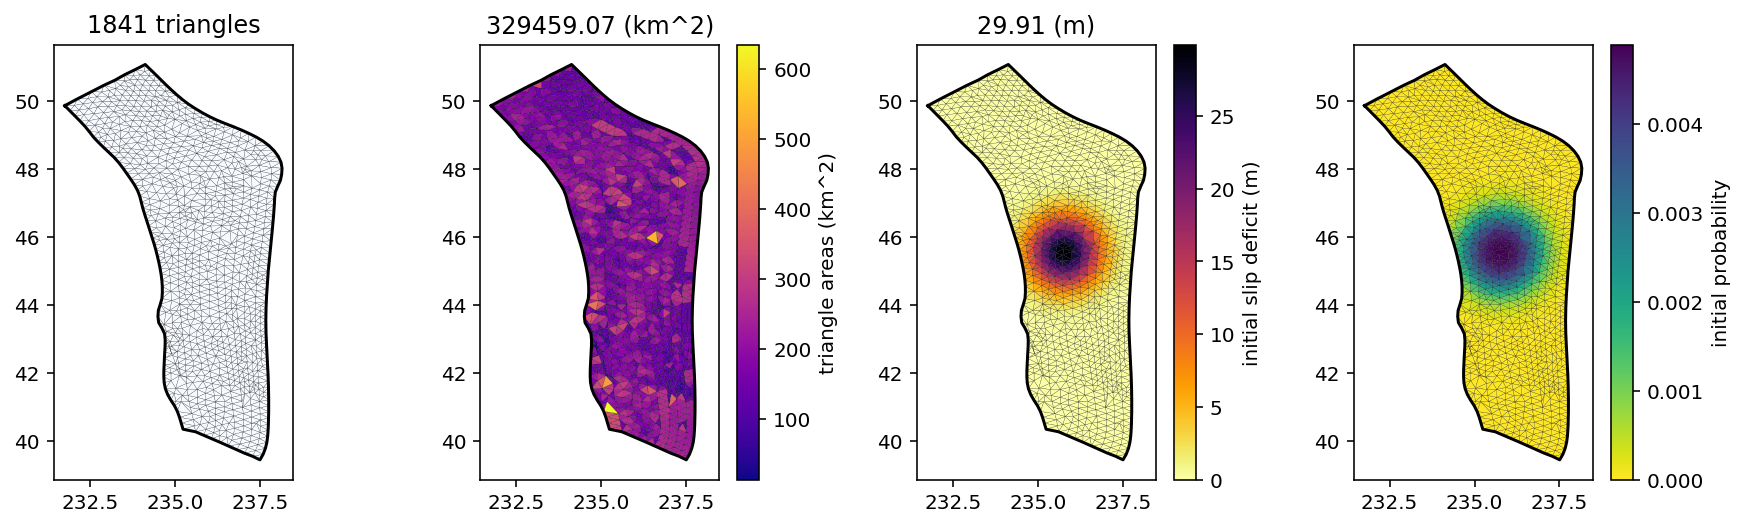

In [7]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([30.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]
slip_deficit = np.copy(initial_dip_slip_deficit)
t = None



initial_probability = get_probability(initial_dip_slip_deficit, t)


# Plot all mesh data and initial slip deficit condition
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
pc = plot_meshes(meshes, np.zeros(meshes[0].areas.size), plt.gca(), "Blues")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"{meshes[0].n_tde} triangles")

plt.subplot(1, 4, 2)
pc = plot_meshes(meshes, meshes[0].areas / 1e6, plt.gca(), "plasma")
plt.colorbar(pc, label="triangle areas (km^2)")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"{np.sum(meshes[0].areas) / KM2_TO_M2:0.2f} (km^2)")

plt.subplot(1, 4, 3)
pc = plot_meshes(meshes, initial_dip_slip_deficit, plt.gca(), "inferno_r")
plt.colorbar(pc, label="initial slip deficit (m)")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"{np.max(initial_dip_slip_deficit):0.2f} (m)")

plt.subplot(1, 4, 4)
pc = plot_meshes(meshes, initial_probability, plt.gca(), "viridis_r")
plt.colorbar(pc, label="initial probability")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.show()


In [8]:
event = create_event(meshes, initial_probability)

# Update slip deficit
updated_slip_deficit = slip_deficit - event.slip_all_elements

print("Event data:")
print("Hypocenter lon, lat, dep, TDE index")
print("theory rupture area")
print("actual rupture area")
print(f"{event.moment_magnitude=}")
print(f"{event.moment[0]=:0.3} (N m)")
print(f"{event.n_eigenvalues=}")


Event data:
Hypocenter lon, lat, dep, TDE index
theory rupture area
actual rupture area
event.moment_magnitude=array([9.])
event.moment[0]=3.55e+22 (N m)
event.n_eigenvalues=565


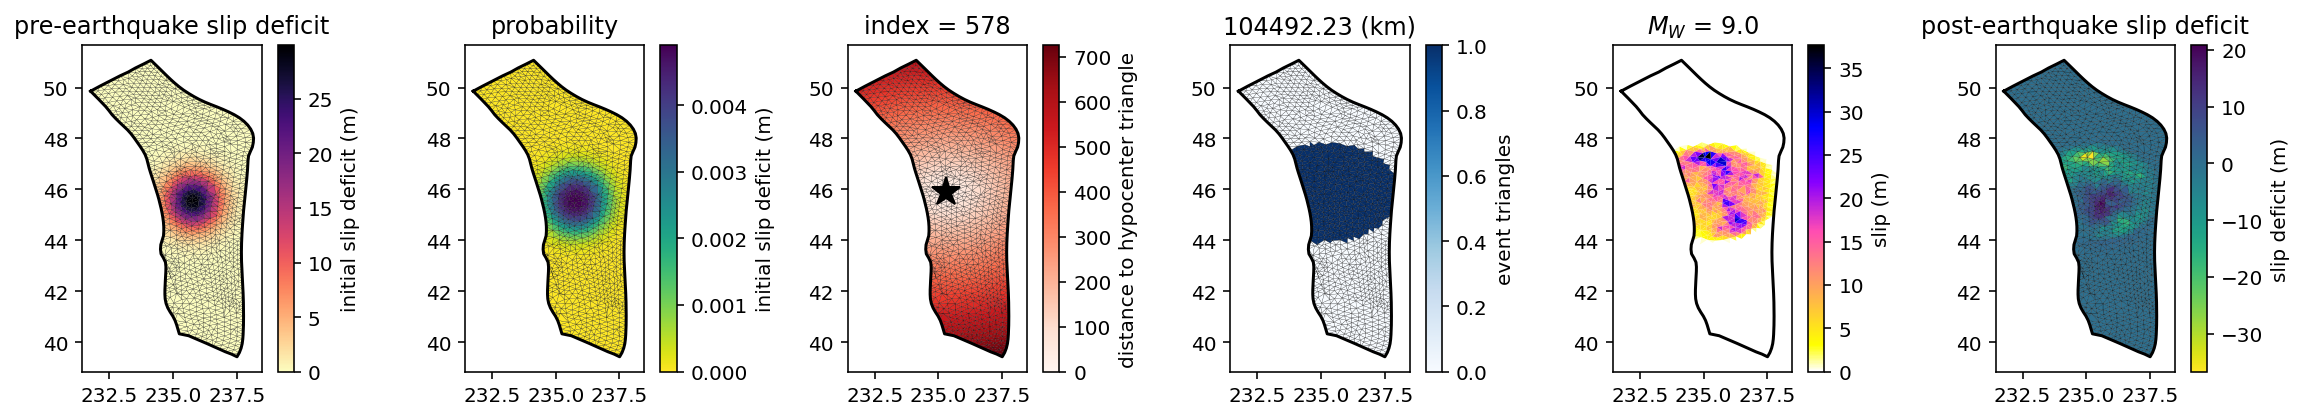

In [9]:
# Plot distances from current event hypocenter triangle
plt.figure(figsize=(20, 3))

# Plot pre-earthquake slip deficit
plt.subplot(1, 6, 1)
pc = plot_meshes(meshes, slip_deficit, plt.gca(), "magma_r")
plt.colorbar(pc, label="initial slip deficit (m)")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"pre-earthquake slip deficit")

# Plot current probability
plt.subplot(1, 6, 2)
pc = plot_meshes(meshes, initial_probability, plt.gca(), "viridis_r")
plt.colorbar(pc, label="initial slip deficit (m)")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"probability")

plt.subplot(1, 6, 3)
pc = plot_meshes(
    meshes,
    event.hypocenter_triangle_to_all_triangles_distances / 1e3,
    plt.gca(),
    "Reds",
)
plt.colorbar(pc, label="distance to hypocenter triangle")
plt.plot(
    meshes[0].centroids[event.hypocenter_triangle_index, 0],
    meshes[0].centroids[event.hypocenter_triangle_index, 1],
    "*k",
    markersize=15,
)
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"index = {event.hypocenter_triangle_index[0]}")

# Plot triangles involved in current event
plt.subplot(1, 6, 4)
fill_value = np.zeros(meshes[0].n_tde)
fill_value[event.triangle_index] = 1
pc = plot_meshes(meshes, fill_value, plt.gca(), "Blues")
plt.colorbar(pc, label="event triangles")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"{event.actual_area / KM2_TO_M2:0.2f} (km)")

# Plot slip distribution
plt.subplot(1, 6, 5)
fill_value = np.zeros(meshes[0].n_tde)
fill_value[event.triangle_index] = event.slip
x_coords = meshes[0].meshio_object.points[:, 0]
y_coords = meshes[0].meshio_object.points[:, 1]
vertex_array = np.asarray(meshes[0].verts)
ax = plt.gca()
xy = np.c_[x_coords, y_coords]
verts = xy[vertex_array]
pc = matplotlib.collections.PolyCollection(
    verts,
    edgecolor=None,
    cmap="gnuplot2_r",
    linewidth=0,
    alpha=1.0,
)
pc.set_array(fill_value)
ax.add_collection(pc)
ax.autoscale()
plt.gca().set_aspect("equal")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.colorbar(pc, label="slip (m)")
plt.title(f"$M_W$ = {event.moment_magnitude[0]:0.3}")

plt.subplot(1, 6, 6)
pc = plot_meshes(meshes, updated_slip_deficit, plt.gca(), "viridis_r")
plt.colorbar(pc, label="slip deficit (m)")
plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
plt.title(f"post-earthquake slip deficit")
plt.show()


In [10]:
# TODO: Remove dependence on celeri?  Extract mesh read in function? Just read a mesh_parameters.json file?
# TODO: Find nodes meshes[0].verts
# TODO: Case for when area is a single triangle or less
# TODO: Set minimum earthquake size based on smallest mesh element
# TODO: Adjust probability function to take into account negative slip deficits (set to zero)
# TODO: Name for slip deficit at each time step
# TODO: Introduce t as a variable
# TODO: Write probability function
# TODO: Time step plotting to function
# TODO: Add an area scaling factor (> 1) so that slip isn't over estimated
